In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats 
import emcee 

from math import *
import sys
import re
import random
import subprocess 
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import corner

from ratios import r02, r10

In [2]:
freqs = pd.read_table('7970740-freqs.dat', sep='\s+')
freqs.head()

,n,l,nu,dnu
0,13,1,2598.383495,0.588931
1,14,1,2774.022574,1.129501
2,15,1,2945.514652,0.174797
3,16,0,3035.598342,0.152819
4,16,1,3117.857020,0.136164


In [3]:
obs_r02 = r02(freqs)
obs_r10 = r10(freqs)

r02_interp_freqs = obs_r02['freqs']
r10_interp_freqs = obs_r10['freqs']

print(r02_interp_freqs)
print(r10_interp_freqs)

[3369.65793372 3542.20003263 3714.75021773 3888.75730197 4061.81327253
 4234.77993254 4411.17043124 4586.69141157 4761.52420681 4938.47618549
 5111.8689779  5284.77005007]
[3207.0969515  3379.36763931 3551.64830171 3724.28709494 3897.2886574
 4070.35749431 4243.87985003 4417.59908676 4592.83433385 4766.43550485
 4941.06382251 5117.76835496]


In [4]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


In [58]:
np.set_printoptions(precision=10)

#n_perturb = 10
#np.random.seed(0)
#r02s = np.array([r02(freqs, perturb=True)['ratios']
#        for ii in range(n_perturb)])
#r10s = np.array([r10(freqs, perturb=True)['ratios']
#        for ii in range(n_perturb)])

def progress(func, freqs, i, max_i):
    update_progress((i+1)/max_i)
    return func(freqs, perturb=True)['ratios']

def get_ratios(func, freqs, n_perturb=100000):
    np.random.seed(0)
    return np.array([progress(func, freqs, ii, n_perturb)
        for ii in range(n_perturb)])

r02s = get_ratios(r02, freqs)
r10s = get_ratios(r10, freqs)

rs = np.hstack((r02s, r10s))

Progress: [####################] 100.0%


In [4]:
y_star = pd.DataFrame([[5309./5772., -0.54] + \
        list(obs_r02['ratios']) + list(obs_r10['ratios'])],
    columns=['Teff', 'Fe_H'] + list(obs_r02['names'] + obs_r10['names']))

y_star

,Teff,Fe_H,r02_17,r02_18,r02_19,r02_20,r02_21,r02_22,r02_23,r02_24,...,r10_19,r10_20,r10_21,r10_22,r10_23,r10_24,r10_25,r10_26,r10_27,r10_28
0,0.919785,-0.54,0.063186,0.056338,0.054542,0.055206,0.049283,0.049298,0.052405,0.036912,...,0.015446,0.01521,0.014888,0.014634,0.014336,0.015857,0.014204,0.010339,0.007882,0.019809


In [6]:
Sigma = np.cov(rs.T) 
Sigma = np.vstack([np.zeros(Sigma.shape[0]), np.zeros(Sigma.shape[0]), Sigma])
Sigma = np.insert(Sigma, 0, np.zeros(Sigma.shape[0]), axis=1)
Sigma = np.insert(Sigma, 0, np.zeros(Sigma.shape[0]), axis=1)
Sigma[0,0] = (77/5772)**2
Sigma[1,1] = 0.1**2
print('Condition number:', np.linalg.cond(Sigma))

np.set_printoptions(precision=10)
unc = np.sqrt(np.diag(Sigma))
min_unc = np.min(unc)
print('Uncerainties:')
print(unc)
print('Smallest:', min_unc)

NameError: name 'rs' is not defined

In [63]:
Sigma_inv = np.linalg.inv(Sigma)
print(Sigma_inv.shape)
np.save('Sigma_inv', Sigma_inv)

(26, 26)


In [5]:
Sigma_inv = np.load('Sigma_inv.npy')

NameError: name 'Sigma' is not defined

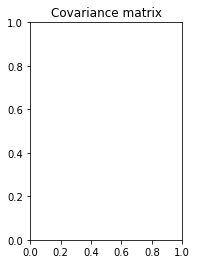

In [8]:
plt.subplot(121)
plt.title('Covariance matrix')
plt.imshow(Sigma, interpolation='nearest')
plt.subplot(122)
plt.title('Inverse')
plt.imshow(Sigma_inv, interpolation='nearest')
plt.show()

In [7]:
## t = 10.67   +/- 0.44
## M =  0.7669 +/- 0.0036
## Y =  0.2717 +/- 0.0020
## Z =  0.0124 +/- 0.0013
## a =  1.931  +/- 0.074
## b =  0.     +/- 0.01
#prior_mu =          [10.67, 0.7669, 0.2717, 0.0124, 1.931, 0.]
#prior_cov = np.diag([ 0.44, 0.0036, 0.0020, 0.0013, 0.074, 0.01])
#                    age     M    Y     Z       alpha beta  R1    R2    R3    R4    R5
#prior_mu  =         [11,     0.8, 0.25, 0.005,  1.8,  0.,   1,    1,    1,    1,    1]
#prior_cov = np.diag([ 1,     0.1, 0.02, 0.005,   0.1, 0.01, 0.01, 0.05, 0.05, 0.08, 0.07])

prior_mu  =         [   1,    1,    1,    1,    1]
prior_cov = np.diag([0.01, 0.05, 0.05, 0.08, 0.07])
X_max     = [13.799, 1,   0.4,  0.02,  2.5,  0.2,  2,  2,  2,  2,  2]
X_min     = [0,      0.5, 0.1,  0.001, 0.2, -0.2,  0,  0,  0,  0,  0]

def get_theta(theta, Y_p=0.2463, dYdZ=1.42, alpha_solar=1.85, beta=0):
    #age, M, Z = theta
    #Y = Y_p + dYdZ * Z
    #return np.array([age, M, Y, Z, alpha_solar, beta])
    return np.hstack((theta, [beta]))

def lnprior(theta):
    print("lnprior")
    if len(theta) < 6: 
        _theta = get_theta(theta)
    else:
        _theta = np.copy(theta)
    #print(_theta)
    if any(_theta >= X_max) or any(_theta <= X_min):
        print("Out of bounds")
        #print(_theta)
        return -np.inf
    #return 0.0 # flat prior 
    _lnprior = sp.stats.multivariate_normal.logpdf(
        _theta[-5:], mean=prior_mu, cov=prior_cov)
    return _lnprior 

def lnlike(theta):
    if len(theta) < 6: 
        _theta = get_theta(theta)
    else:
        _theta = np.copy(theta)
    #y = scaler.inverse_transform(ann.predict([_theta]))[0]
    
    # tau, M, Y, Z, alpha, beta, rate1, rate2, rate3, rate4, rate5
    _theta[0] = float(str(_theta[0]) + 'e9')
    
    # generate a random temp filename and make sure it's not in use 
    n = random.getrandbits(64)
    while os.path.exists(os.path.join('MCMC_calcs', str(n))):
        n = random.getrandbits(64)
    
    # call ASTEC 
    bash_cmd = "./astec_mcmc.sh -d MCMC_calcs -n " + str(n) + " -r " + \
        " %.8f ".join(["-t",  "-M",  "-Y",  "-Z",  "-a",  "-b", 
                       "-r1", "-r2", "-r3", "-r4", "-r5", ""]) % tuple(_theta)
    process = subprocess.Popen(bash_cmd.split(), shell=False)
    process.wait()
    
    freq_file = os.path.join('MCMC_calcs', str(n) + '.freqs')
    hist_file = os.path.join('MCMC_calcs', str(n) + '.dat')
    gong_file = os.path.join('MCMC_calcs', str(n) + '.FGONG.dat')
    if  not os.path.exists(freq_file) or \
        not os.path.exists(hist_file) or \
        not os.path.exists(gong_file):
            return -np.inf
    
    nus = pd.read_table(freq_file, sep='\s+', comment='#', 
        names=['l', 'n', 'nu', 'E', 'n_p', 'n_g'])
    
    # compute ratios 
    r02s = r02(nus, interp_freqs=r02_interp_freqs)
    r10s = r10(nus, interp_freqs=r10_interp_freqs)
    
    # obtain Teff 
    hist_file = os.path.join('MCMC_calcs', str(n) + '.dat')
    hist = pd.read_table(hist_file, sep='\s+', comment='#', 
        names=['Model', 'M', 'age', 'R', 'Teff', 'L', 'X_c', 'qc'])
    Teff = hist['Teff'].values[-1]
    
    # obtain [Fe/H]
    gong_file = os.path.join('MCMC_calcs', str(n) + '.FGONG.dat')
    gong = pd.read_table(gong_file, sep='\s+')
    FeH = log10(gong['Z'].values[0]/gong['X'].values[0]/0.02307)
    
    # delete files 
    os.remove(freq_file)
    os.remove(hist_file)
    os.remove(gong_file)
    
    y = pd.DataFrame([[Teff/5772., FeH] + \
            list(r02s['ratios']) + list(r10s['ratios'])],
        columns=['Teff', 'Fe_H'] + list(obs_r02['names'] + obs_r10['names']))
    
    if y.isnull().values.any():
        print("NaNs")
        return -np.inf
    
    resid = y.iloc[0] - y_star.iloc[0]
    chi2 = np.dot(resid, np.dot(Sigma_inv, resid))
    
    return -chi2/2.

def lnprob(theta, i=0, N=0, size=0):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [8]:
#theta = [11, 0.75408, 0.005]
theta = [11, 0.73, 0.25, 0.005, 1.7, 0., 1., 1., 1., 1., 1.]
print(theta)

[11, 0.73, 0.25, 0.005, 1.7, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [32]:
-2*lnprob(theta)

lnprior


inf

In [83]:
#if y.isnull().values.any():
#    print("asdf")

In [82]:
#theta = [1.0938723839e+01, 7.6804166329e-01, 2.5419074804e-01, 4.1340284067e-03,
# 1.6986679312e+00, 7.1168162389e-04, 9.9686174752e-01, 1.0000764640e+00,
# 9.8985188705e-01, 1.0051456307e+00, 9.9102590244e-01]
#
#theta

In [9]:
ndim, nwalkers = len(theta), len(theta)*2


cov = [1, 0.03, 0.01, 0.001, 0.1, 0.01, 0.01, 0.05, 0.05, 0.08, 0.07]
#prior_cov = np.diag([ 1,     0.1, 0.02, 0.005,   0.1, 0.01, 0.01, 0.05, 0.05, 0.08, 0.07])
np.random.seed(0)
pos = np.array([[np.random.normal(theta[ii], cov[ii]/10) 
                 for ii in range(ndim)]
       for jj in range(nwalkers)])

pos.shape

(22, 11)

In [70]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=1)
sampler.run_mcmc(pos, 2)

lnprior
[ 1.1029597077e+01  7.4145198677e-01  2.4945330987e-01  5.2154536297e-03
  1.7059813402e+00 -6.3376959174e-04  1.0001154701e+00  9.9948161810e-01
  1.0044778950e+00  1.0027764958e+00  1.0022565395e+00]
lnprior
[ 1.1067036407e+01  7.5369524913e-01  2.4741372848e-01  6.0440796519e-03
  1.6968362994e+00 -9.9633518917e-05  9.9995864655e-01  9.9291246311e-01
  9.9703480465e-01  1.0035657051e+00  9.9895271009e-01]
lnprior
[ 1.0983126521e+01  7.5387408005e-01  2.4828218210e-01  4.7115511713e-03
  1.7171519726e+00 -6.9961680138e-04  9.9972147419e-01  9.9486963501e-01
  1.0065625956e+00  1.0022149004e+00  1.0050005939e+00]
lnprior
[1.0972732110e+01 7.4942850369e-01 2.4987424303e-01 4.6132663423e-03
 1.6824451059e+00 1.3222324763e-03 1.0008918346e+00 1.0065206501e+00
 9.9318342152e-01 1.0002831799e+00 1.0023002252e+00]
lnprior
[1.1061597940e+01 7.6344965001e-01 2.4995446165e-01 5.8319534142e-03
 1.6807715994e+00 5.1202292620e-04 9.9897482073e-01 1.0031861836e+00
 1.0079651992e+00 9.94872

ValueError: lnprob returned NaN.

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
arr = sampler.chain
for i in range(ndim):
    ax = axes[i]
    #arr = sampler.chain[..., i]
    #arr = arr.reshape(-1, arr.shape[-1])
    #arr = sampler.chain.reshape((-1, ndim))
    for jj in range(arr.shape[0]):
        ax.plot(arr[jj, :, i], alpha=0.3)
    #ax.plot(arr[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, arr.shape[1])
    ax.set_ylabel(X_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#fig.savefig('chains.pdf')
#fig.show()

In [ ]:
sampler.get_autocorr_time()#c=2)

In [34]:
samples = sampler.chain[:, -2000:, :].reshape((-1, ndim))
arr = samples
samples.shape

NameError: name 'sampler' is not defined

In [6]:
import pickle as pkl
arr = pkl.load(open('chain.pkl', 'rb'))
#sampler = pkl.load(open('sampler.pkl', 'rb'))

In [12]:
from emcee import autocorr
autocorr.integrated_time(arr, c=0.1, fast=True)

/home/earl/.local/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
/home/earl/.local/lib/python3.6/site-packages/emcee/autocorr.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return acf / acf[m]
/home/earl/.local/lib/python3.6/site-packages/emcee/autocorr.py:105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

AutocorrError: The chain is too short to reliably estimate the autocorrelation time

In [11]:
arr = arr[:, -250:, :].reshape((-1, ndim))
arr.shape

(10000, 11)

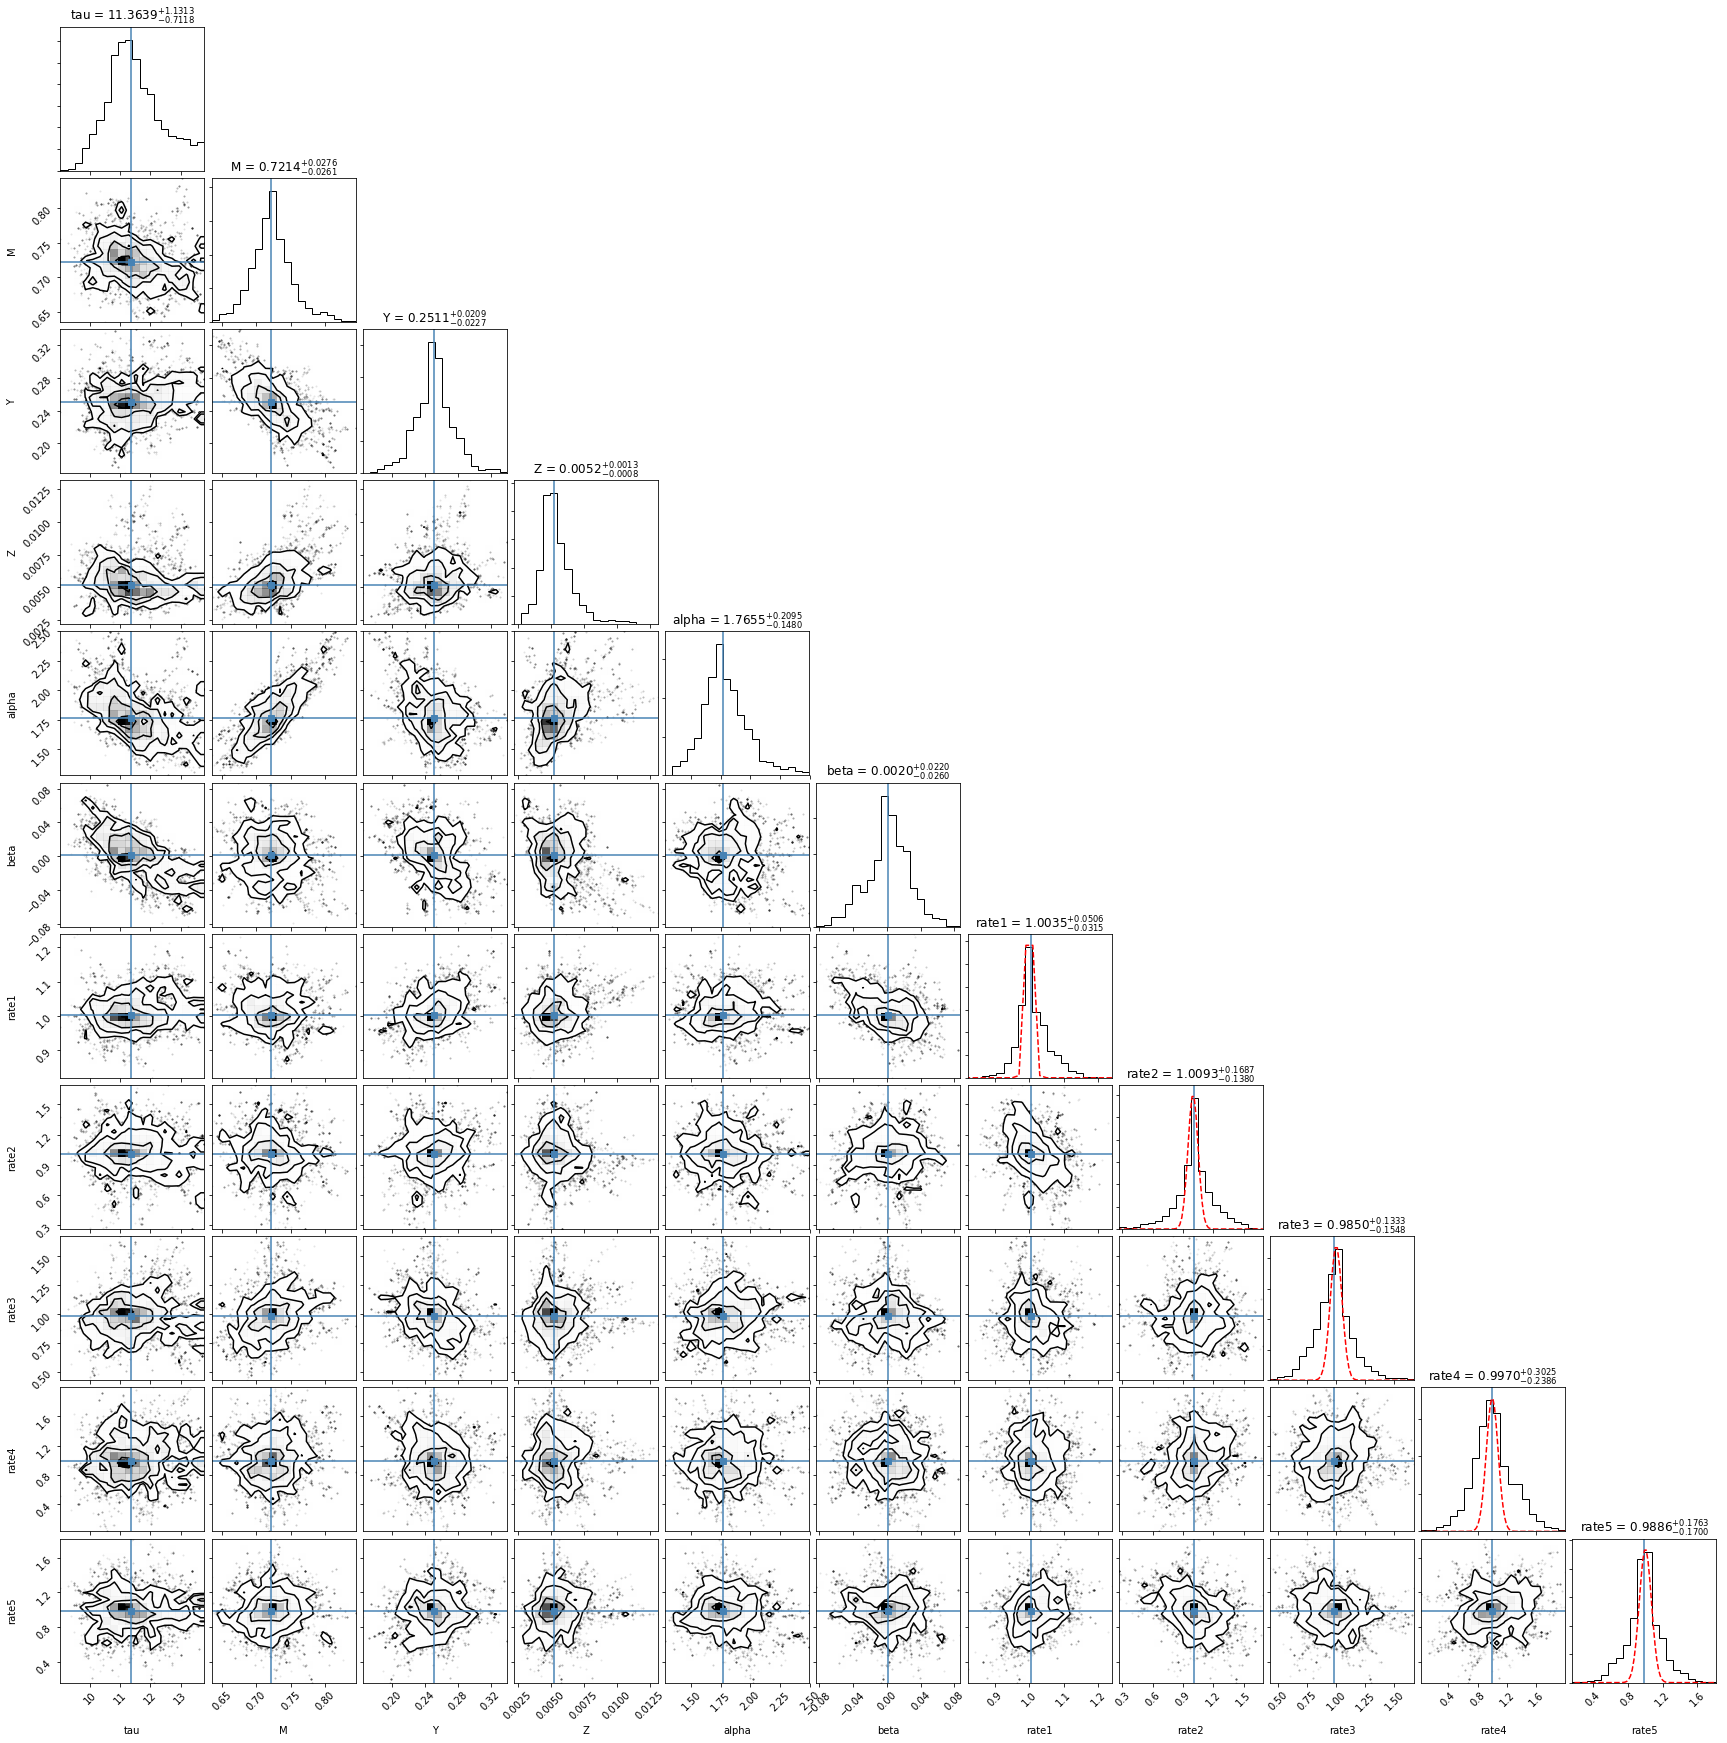

In [12]:
X_labels = ['tau', 'M', 'Y', 'Z', 'alpha', 'beta', 
            'rate1', 'rate2', 'rate3', 'rate4', 'rate5']

fig = corner.corner(arr, labels=X_labels,
    #quantiles=[0.5],
    show_titles=True,
    title_fmt='.4f',
    #color='b',
    truths=np.percentile(arr, 50, axis=0),
    #range=[(X_min[i], X_max[i]) for i in range(len(X_labels))],
    #truth_color='b',
    title_kwargs={"fontsize": 12})

axes = np.array(fig.axes).reshape((len(X_labels), len(X_labels)))

plot_priors = True 

if plot_priors:
    for ii in range(ndim-5, ndim):
        ax = axes[ii, ii]

        # plot priors 
        xs = np.linspace(X_min[ii], X_max[ii], num=100)
        ys = sp.stats.norm.pdf(xs, loc=prior_mu[ii-ndim+5], scale=prior_cov[ii-ndim+5, ii-ndim+5])
        ymax = ax.get_ylim()[1]
        ax.plot(xs, ymax * ys/max(ys) * 0.92, 'r--')

        # plot starting point 
        #ax.axvline(best[ii], color='k', linestyle='--')

"""
Zcol = 3
for i in range(Zcol, len(X_labels)): 
    ax = axes[i, Zcol]
    ax.set_xscale('log')
    if i < (len(X_labels)-1):
        ax.set_xticklabels([])

for i in range(0, Zcol): 
    ax = axes[Zcol, i]
    ax.set_yscale('log')
    if i > 0:
        ax.set_yticklabels([])
"""

#fig.savefig('AGSS09-corner.pdf')
fig.show()

In [32]:
arr.T

array([[11.4637119 , 11.50899945, 11.56444442, ..., 11.30939951,
        11.30939951, 11.3391591 ],
       [ 0.71957833,  0.71978913,  0.72016701, ...,  0.74711793,
         0.74711793,  0.74847458],
       [ 0.25117137,  0.25134461,  0.25175085, ...,  0.2176008 ,
         0.2176008 ,  0.21700523],
       ...,
       [ 0.99959302,  0.99949427,  0.99868094, ...,  1.38320465,
         1.38320465,  1.37036543],
       [ 0.99941082,  1.00155716,  1.0018678 , ...,  0.71196404,
         0.71196404,  0.71510425],
       [ 1.00122448,  1.00660126,  1.00661719, ...,  0.39317333,
         0.39317333,  0.39128841]])

In [36]:
np.savetxt('beta_samples.dat', arr, header=' '.join(X_labels))

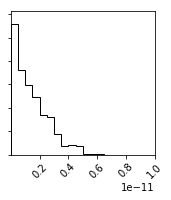

In [27]:
fig = corner.corner(abs(arr[:,5] / 13.799e9), range=[(0, 1e-11)])

In [37]:
#print(samples)
list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
    zip(*np.percentile(arr, [16, 50, 84], axis=0))))

[(11.444732737804518, 1.2131031084208779, 0.8949182525032331),
 (0.722281156046183, 0.02926095976719434, 0.02972942199718287),
 (0.25142242089823025, 0.02342549485093781, 0.025874662911004098),
 (0.005268578061455509, 0.0013722818163694741, 0.0008373003184800392),
 (1.7913665855900023, 0.21059158252774335, 0.18323606988308283),
 (0.004008127221387128, 0.022683886635984224, 0.032917821790067914),
 (1.0081048415867877, 0.05620115922310731, 0.039453014568304634),
 (1.0147401453560654, 0.19181214397434498, 0.17903378298533856),
 (0.9690268014230825, 0.17273496982958392, 0.16320783697697283),
 (1.0120423325178698, 0.3291782877633991, 0.2846677798305225),
 (0.9755193041911121, 0.2087118544006541, 0.19500581238017978)]

(array([  28.,  261.,  878., 1110., 2725., 2649., 1573.,  543.,  220.,
          13.]),
 array([-6.00971114e-12, -4.77831397e-12, -3.54691679e-12, -2.31551961e-12,
        -1.08412244e-12,  1.47274738e-13,  1.37867191e-12,  2.61006909e-12,
         3.84146627e-12,  5.07286344e-12,  6.30426062e-12]),
 <a list of 10 Patch objects>)

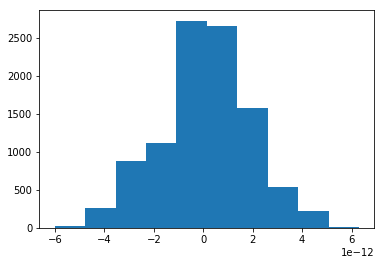

In [48]:
plt.hist(arr[:,5] / 13.799e9)

In [1]:
plt.subplot(121)
plt.hist(np.abs(arr[:,5]) / 13.799e9, density=True, histtype='step')

plt.subplot(122)
plt.hist(np.abs(arr[:,5]) / 13.799e9, density=True, histtype='step', cumulative=True)
plt.axhline(0.95, linestyle='--', color='k')
plt.axvline(0.05115 / 13.799e9, linestyle='--', color='k')
plt.show()

NameError: name 'plt' is not defined

In [56]:
counts, bins = np.histogram(np.abs(arr[:,5]), bins=1000)
cdf = np.cumsum(counts)
cdf = cdf / np.max(cdf)
#print(cdf)
#print(bins)
print(bins[np.where(cdf >= 0.95)][0])

0.05115456625563255


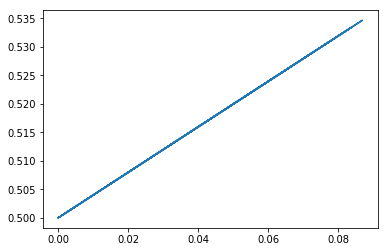

In [20]:
plt.plot(np.abs(arr[:,5]), scipy.stats.norm.cdf(np.abs(arr[:,5])))

In [ ]:
print(np.mean(arr[:, -1]))
print(np.std(arr[:, -1]))

In [ ]:
from sklearn.cluster import MeanShift
from scipy.stats import gaussian_kde

# calculate modes of the posterior distribution 
mean_shift = MeanShift(bin_seeding=True)
mean_shift.fit(arr)
modes = mean_shift.cluster_centers_

# now find the mode with the highest probability 
kde = gaussian_kde(arr.T)
X_best = modes[np.argmax([kde.pdf(mode) for mode in modes])]

print(X_best)

In [ ]:
ratio_names = list(KIC.columns[2:])
radial_orders = np.array(list(map(lambda x: int(x.split('_')[1]), ratio_names)))
offset = np.array(list(map(lambda x: 0.1 if x.split('_')[0] == 'r10' else -0.1, ratio_names)))

#X_best = [np.median(arr[:,ii]) for ii in range(ndim)]
#print(X_best)

y_pred = scaler.inverse_transform(ann.predict([X_best]))[0]

plt.axhline(0, linestyle='--', color='k')

plt.errorbar(radial_orders[offset<0] + offset[offset<0], 
             (y_star[2:] - y_pred[2:])[offset<0], 
             yerr=np.sqrt(np.diag(Sigma))[2:][offset<0], 
             label='r02',
             fmt='r.')
plt.errorbar(radial_orders[offset>0] + offset[offset>0], 
             (y_star[2:] - y_pred[2:])[offset>0], 
             yerr=np.sqrt(np.diag(Sigma))[2:][offset>0], 
             label='r10',
             fmt='b.')

plt.xlabel('Radial order n')
plt.ylabel('Ratio residual')
plt.legend(loc='lower left')

plt.savefig('AGSS09-best_model.pdf')
plt.show()

chi2 = -2*lnlike(X_best) 
chi2_red = chi2 / (len(y_star) - X.shape[1])
print(chi2, chi2_red)

In [ ]:
pos2 = pos[:,:5]
sampler2 = emcee.EnsembleSampler(nwalkers, 5, lnprob, threads=4)
sampler2.run_mcmc(pos2, 1000)

In [ ]:
print(sampler2.chain.shape)
#print(ndim)
samples2 = sampler2.chain[:, -100:, :].reshape((-1, 5))

arr2 = samples2
#samples.shape

fig = corner.corner(arr2, labels=X_labels[:5],
    #quantiles=[0.5],
    show_titles=True,
    title_fmt='.4f',
    #color='b',
    truths=np.percentile(arr2, 50, axis=0),
    range=[(X_min[i], X_max[i]) for i in range(len(X_labels)-1)],
    #truth_color='b',
    title_kwargs={"fontsize": 12})


axes = np.array(fig.axes).reshape((len(X_labels)-1, len(X_labels)-1))

for ii in range(len(X_labels)-1):
    ax = axes[ii, ii]
    xs = np.linspace(X_min[ii], X_max[ii], num=100)
    ys = sp.stats.norm.pdf(xs, loc=prior_mu[ii], scale=prior_cov[ii, ii])
    ymax = ax.get_ylim()[1]
    ax.plot(xs, ymax * ys/max(ys) * 0.92, 'r--')

Zcol = 3
for i in range(Zcol, len(X_labels)-1): 
    ax = axes[i, Zcol]
    ax.set_xscale('log')
    if i < (len(X_labels)-1):
        ax.set_xticklabels([])

for i in range(0, Zcol): 
    ax = axes[Zcol, i]
    ax.set_yscale('log')
    if i > 0:
        ax.set_yticklabels([])

#fig.savefig('corner.pdf')
#fig.show()

In [ ]:
X_best2 = [np.median(arr2[:,ii]) for ii in range(5)]
y_pred2 = scaler.inverse_transform(ann.predict([get_theta(X_best2)]))[0]
#plt.errorbar(y_star[2:], y_star[2:] - y_pred[2:], yerr=np.sqrt(np.diag(Sigma))[2:], fmt='r.')
chi2_no_beta = -2*lnlike(X_best2) / (len(y_star) - X.shape[1] - 1)
print(chi2_no_beta)

In [ ]:
sp.stats.chi2.pdf(chi2_no_beta - chi2_beta, df=1)
sp.stats.chi2.pdf(-2*lnlike(X_best2) - -2*lnlike(X_best), df=1)